## The Model

Consider a data set $\mathbf{X} = \{\mathbf{x}_n\}$ of $N$ data
points, where each data point is $D$-dimensional, $\mathbf{x}_n \in
\mathbb{R}^D$. We aim to represent each $\mathbf{x}_n$ under a latent
variable $\mathbf{z}_n \in \mathbb{R}^K$ with lower dimension, $K <
D$. The set of principal axes $\mathbf{W}$ relates the latent variables to
the data.

Specifically, we assume that each latent variable is normally distributed,

$$
\begin{equation*}
\mathbf{z}_n \sim N(\mathbf{0}, \mathbf{I}).
\end{equation*}
$$

The corresponding data point is generated via a projection,

$$
\begin{equation*}
\mathbf{x}_n \mid \mathbf{z}_n
\sim N(\mathbf{W}\mathbf{z}_n, \sigma^2\mathbf{I}),
\end{equation*}
$$

where the matrix $\mathbf{W}\in\mathbb{R}^{D\times K}$ are known as
the principal axes. In probabilistic PCA, we are typically interested in
estimating the principal axes $\mathbf{W}$ and the noise term
$\sigma^2$.

Probabilistic PCA generalizes classical PCA. Marginalizing out the the
latent variable, the distribution of each data point is

$$
\begin{equation*}
\mathbf{x}_n \sim N(\mathbf{0}, \mathbf{W}\mathbf{W}^\top + \sigma^2\mathbf{I}).
\end{equation*}
$$

Classical PCA is the specific case of probabilistic PCA when the
covariance of the noise becomes infinitesimally small, $\sigma^2 \to 0$.

We set up our model below. In our analysis, we assume $\sigma$ is known, and
instead of point estimating $\mathbf{W}$ as a model parameter, we
place a prior over it in order to infer a distribution over principal
axes. We'll express the model as a TFP JointDistribution, specifically, we'll
use [JointDistributionCoroutineAutoBatched](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutineAutoBatched).

jax.local_device_count 32


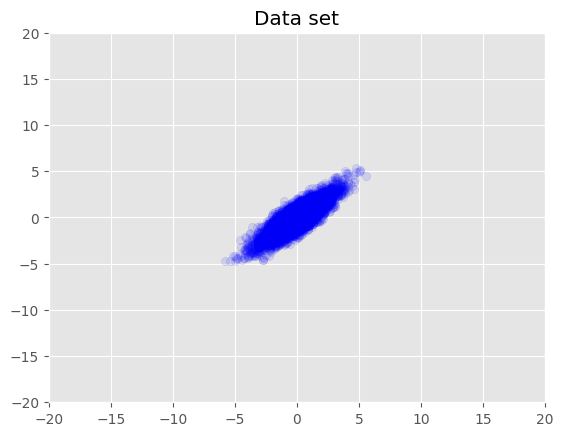

In [114]:
from main import*
import seaborn as sns
m = bi(platform='cpu')
plt.style.use("ggplot")
warnings.filterwarnings('ignore')


num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

# Simulate data
def sim_data(data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 0): 
    w = bi.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w', sample=True, seed=seed)
    z = bi.dist.normal(0, 1, shape=(latent_dim, num_datapoints), name='z', sample=True, seed=seed)
    x = bi.dist.normal(w @ z, stddv_datapoints, shape=(data_dim, latent_dim), name='x', sample=True, seed=seed)
    return w, z, x

actual_w, actual_z, x_train =sim_data(data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 20)
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()


## Model

In [156]:
# Model using simulated data
def model(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints, seed = 0): 
    w = bi.dist.normal(0, 1, shape=(data_dim, latent_dim), name='w')
    z = bi.dist.normal(0, 1, shape=(latent_dim, num_datapoints))
    lk('Y', Normal(w @ z, stddv_datapoints), obs=x_train)  
    m.data_on_model = dict(
    x_train = x_train, 
    data_dim = data_dim, 
    latent_dim = latent_dim, 
    num_datapoints = num_datapoints, 
    stddv_datapoints = stddv_datapoints
)

m.run(model) 
summary = m.summary()
posteriors = jnp.concatenate([actual_w.flatten(), actual_z.flatten()]) # concatenate the actual values of w and z

sample: 100%|██████████| 1000/1000 [00:04<00:00, 244.88it/s, 31 steps of size 1.70e-01. acc. prob=0.86]


BI took: 4.1255 seconds


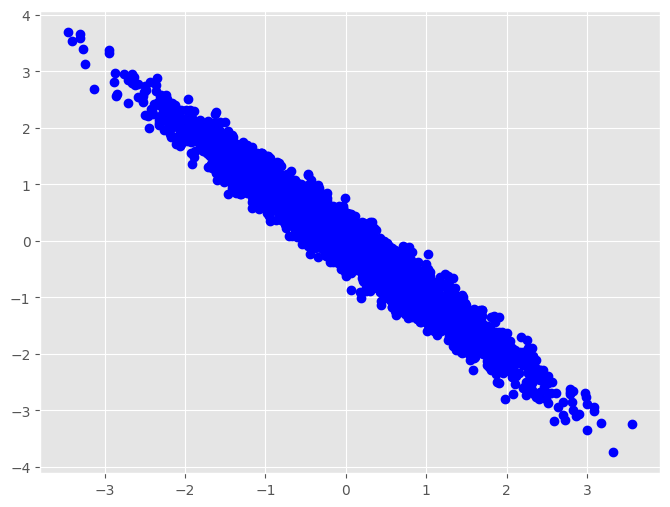

In [158]:
# Plot real values Vs expected values
plt.figure(figsize=(8, 6))
plt.plot(summary.iloc[:,0], posteriors, marker='o', linestyle='None', color='b', label='Posteriors')